In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)



In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
left = left.sort_values(by='node')
# インデックスを振り直す
left = left.reset_index(drop=True)
left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [6]:
# 正規化する
left["node_norm"] = left["node"] - left["node"].min() + 2
left["edge_norm"] = left["edge"] - left["edge"].min() + 1

# インデックスを振り直す
left = left.reset_index(drop=True)



In [7]:
def model_uniform_2(x, Np):
    first = (1 - ((4 * x[0]) / (Np * (Np - 1))))**Np
    second = 1 - first
    third = ((Np - 1) / (4 * x[0])) * second
    fourth = 1 - third
    fifth = Np * fourth
    return fifth

In [8]:
x = left["edge_norm"]
y = left["node_norm"]

In [20]:
left.head()

,node,edge,node_norm,edge_norm
0,106,190,2,1
1,136,221,32,32
2,173,312,69,123
3,215,368,111,179
4,217,494,113,305


In [9]:
# 残差
def residual_uniform_2(x, N, M):
    residual = N - model_uniform_2(x, M)
    return residual

In [10]:
# 目的関数
def f_uniform_2(x, N, M):
    return np.sum(residual_uniform_2(x, M, N)**2)

In [25]:
# 最適化
params, _ = optimize.curve_fit(model_uniform_2, x, y, p0=[3])
print("params", params[0])

params 602.9937615795684


In [24]:
# 元の関数に代入する
Np_norm_hat = 602.99
print("+------------------+")
kappa_norm_estimated = []
for i in range(len(x)):
    kappa_norm_estimated.append( (8 * x[i]) / (Np_norm_hat * (Np_norm_hat - 1)) )

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( model_uniform_2(x, Np_norm_hat) )
    M_norm.append( (kappa_norm_estimated[i] * Np_norm_hat * (Np_norm_hat - 1)) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", left["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")

+------------------+
|      DONE        |
+------------------+
| Np:  602.99
| N max:  514
| kappa:  2.2038934802621658e-05
| N:  1.9955922265570298
| M:  0.9999999999999999
+------------------+


+------------------+
|      DONE        |
+------------------+
| Np:  602.99
| N max:  514
| kappa:  2.2038934802621658e-05
| N:  1.9955922265570298
| M:  0.9999999999999999
+------------------+


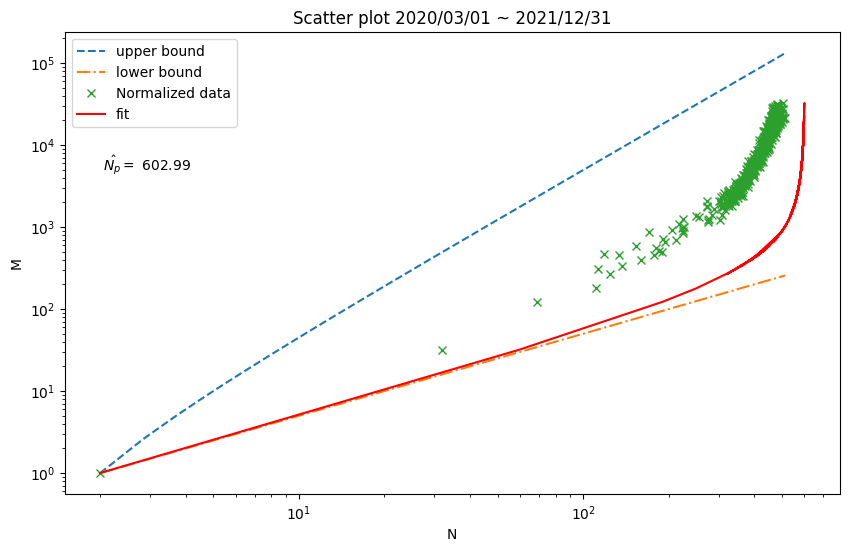

In [23]:
# 可視化
nn = len(left) - 1
xmin = min(y)
xmax = max(y)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

Np_norm_hat = 602.99
print("+------------------+")
kappa_norm_estimated = [((8 * x[i]) / (Np_norm_hat * (Np_norm_hat - 1))) for i in range(len(x))]

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * (1 - (2 / (kappa_norm_estimated[i]*Np_norm_hat))*(1-(1-(kappa_norm_estimated[i]/2))**Np_norm_hat)) )
    M_norm.append( (kappa_norm_estimated[i] * Np_norm_hat * (Np_norm_hat - 1)) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", left["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")



plt.figure(figsize=(10, 6))
plt.title("Scatter plot 2020/03/01 ~ 2021/12/31")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.plot(y, x, "x", label='Normalized data')
plt.plot(N_norm,M_norm,label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [49]:
x_rescale = left["edge_norm"][1:]

In [50]:
y_rescale = left["node_norm"][1:]

In [51]:
# x_rescaleとy_rescaleのインデックスを振り直す
x_rescale = x_rescale.reset_index(drop=True)
y_rescale = y_rescale.reset_index(drop=True)

In [52]:
print("+------------------+")
print("+ X_rescale: ", x_rescale[0:6])
print("+ Y_rescale: ", y_rescale[0:6])
print("+------------------+")

+------------------+
+ X_rescale:  0     32
1    123
2    179
3    305
4    474
5    268
Name: edge_norm, dtype: int64
+ Y_rescale:  0     32
1     69
2    111
3    113
4    118
5    124
Name: node_norm, dtype: int64
+------------------+


In [53]:
# 非線形最小二乗法
# model_uniform_2を使う
for i in range(0, 1001):
    popt, _ = optimize.curve_fit(model_uniform_2, x_rescale, y_rescale, p0=[i])
    print("Initial guess: ", i)
    print("popt: ", popt[0])

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_34830/782253155.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  first = (1 - ((4 * x[0]) / (Np * (Np - 1))))**Np
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_34830/782253155.py:2: RuntimeWarning: invalid value encountered in scalar power
  first = (1 - ((4 * x[0]) / (Np * (Np - 1))))**Np
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_34830/782253155.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  third = ((Np - 1) / (4 * x[0])) * second


Initial guess:  0
popt:  0.7262642621047624
Initial guess:  1
popt:  1.0
Initial guess:  2
popt:  2.0
Initial guess:  3
popt:  3.0
Initial guess:  4
popt:  4.0
Initial guess:  5
popt:  5.0
Initial guess:  6
popt:  6.0
Initial guess:  7
popt:  7.0
Initial guess:  8
popt:  8.0
Initial guess:  9
popt:  9.0
Initial guess:  10
popt:  10.0
Initial guess:  11
popt:  11.0
Initial guess:  12
popt:  5929.7766910978835
Initial guess:  13
popt:  9036.02172190391
Initial guess:  14
popt:  4095.214034836955
Initial guess:  15
popt:  3654.831970670586
Initial guess:  16
popt:  3192.1554351901414
Initial guess:  17
popt:  3256.862191841884
Initial guess:  18
popt:  4418.141111596999
Initial guess:  19
popt:  3385.7107773881357
Initial guess:  20
popt:  18900.698480234576
Initial guess:  21
popt:  3526.7204318131626
Initial guess:  22
popt:  3602.03567304219
Initial guess:  23
popt:  3680.583691707516
Initial guess:  24
popt:  3758.473101703751
Initial guess:  25
popt:  4477.7648043578265
Initial guess

+------------------+
|      DONE        |
+------------------+
| Np:  700
| N max:  514
| N min: 32
| kappa:  0.0005231964030247292
| N:  60.27591803956249
| M:  32.0
+------------------+


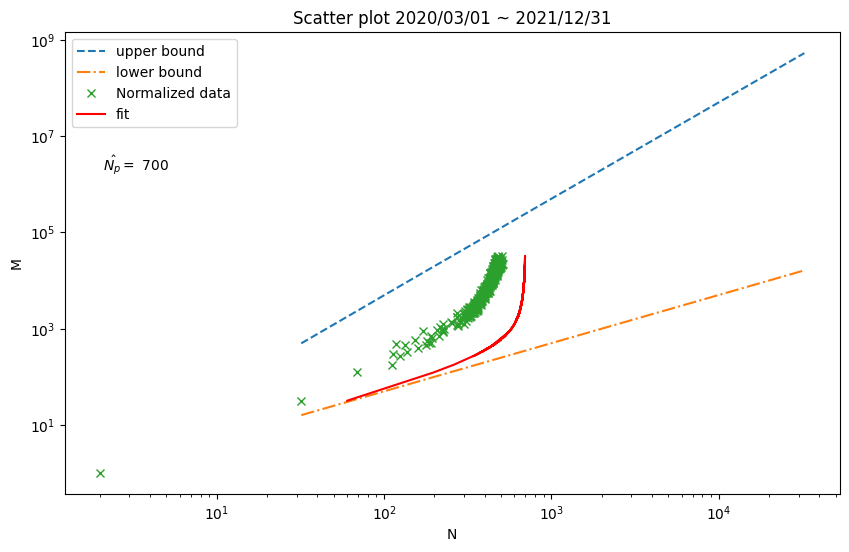

In [56]:
# 可視化
nn = len(x_rescale) - 1
xmin = min(x_rescale)
xmax = max(x_rescale)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

# 元の関数に代入する
Np_norm_hat = 700
print("+------------------+")
kappa_norm_estimated = [((8 * x_rescale[i]) / (Np_norm_hat * (Np_norm_hat - 1))) for i in range(len(x_rescale))]

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * (1 - (2 / (kappa_norm_estimated[i]*Np_norm_hat)) * (1 - (1 - (kappa_norm_estimated[i] / 2))**Np_norm_hat)) )
    M_norm.append( (kappa_norm_estimated[i] * Np_norm_hat * (Np_norm_hat - 1)) / 8 )

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", y_rescale.max())
print("| N min:", y_rescale.min())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")


plt.figure(figsize=(10, 6))
plt.title("Scatter plot 2020/03/01 ~ 2021/12/31")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.plot(y, x, "x", label='Normalized data')
plt.plot(N_norm, M_norm, label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [40]:
x

0         32
1        123
2        179
3        305
4        474
       ...  
602    32505
603    20580
604    27160
605    21537
606    21534
Name: edge_norm, Length: 607, dtype: int64

In [39]:
0.995**554

0.062228127537270916